In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall 
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = 'Datasets/train',
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    class_names = None,
    shuffle = True,
    seed = None,
    validation_split= None,
    subset = None,
    interpolation = 'bilinear',
    follow_links = False,
    batch_size = 32,
    image_size = (224, 224),
    crop_to_aspect_ratio = False
)

val_ds = keras.utils.image_dataset_from_directory(
    directory = 'Datasets/valid',
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    class_names = None,
    shuffle = True,
    seed = None,
    validation_split = None,
    subset = None,
    interpolation = 'bilinear',
    follow_links = False,
    batch_size = 32,
    image_size = (224, 224),
    crop_to_aspect_ratio = False
)

Found 38400 files belonging to 8 classes.
Found 9600 files belonging to 8 classes.


In [4]:
class_names = train_ds.class_names
class_names

['Apple', 'Corn', 'Grape', 'Other', 'Potato', 'Strawberry', 'Tomato', 'Wheat']

In [5]:
def resize_image(image):
    image = tf.image.resize(image, [224, 224])  
    return image

train_ds = train_ds.map(resize_image)
val_ds = val_ds.map(resize_image)

In [6]:
resnet50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
    classes=8
)

for layer in pretrained_model.layers:
    layer.trainable=False

resnet50_model.add(pretrained_model) 
resnet50_model.add(Flatten())
resnet50_model.add(BatchNormalization())
resnet50_model.add(Dense(2500, activation='relu'))
resnet50_model.add(Dropout(0.3))
resnet50_model.add(BatchNormalization())
resnet50_model.add(Dense(2000, activation='relu')) 
resnet50_model.add(Dropout(0.2))
resnet50_model.add(BatchNormalization())
resnet50_model.add(Dense(1500, activation='relu')) 
resnet50_model.add(Dense(1000, activation='relu')) 
resnet50_model.add(Dense(500, activation='relu')) 
resnet50_model.add(Dense(100, activation='relu')) 
resnet50_model.add(Dense(25, activation='relu')) 
resnet50_model.add(Dense(12, activation='relu')) 
resnet50_model.add(Dense(8, activation='softmax'))

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    patience=8,  
    min_delta=0.10,  
    restore_best_weights=True,  
    verbose=1  
)

In [8]:
resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2500)              5122500   
                                                                 
 dropout (Dropout)           (None, 2500)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 2500)             10000     
 hNormalization)                                        

In [9]:
resnet50_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
%%time
history = resnet50_model.fit(train_ds, epochs=10, validation_data=val_ds,callbacks=[early_stopping])

Epoch 1/10
1200/1200 [==============================] - 280s 227ms/step - loss: 0.1577 - accuracy: 0.9497 - val_loss: 0.0411 - val_accuracy: 0.9845
Epoch 2/10
1200/1200 [==============================] - 247s 206ms/step - loss: 0.0365 - accuracy: 0.9898 - val_loss: 0.0260 - val_accuracy: 0.9928
Epoch 3/10
1200/1200 [==============================] - 278s 232ms/step - loss: 0.0298 - accuracy: 0.9911 - val_loss: 0.0186 - val_accuracy: 0.9944
Epoch 4/10
1200/1200 [==============================] - 284s 236ms/step - loss: 0.0213 - accuracy: 0.9932 - val_loss: 0.0185 - val_accuracy: 0.9942
Epoch 5/10
1200/1200 [==============================] - 287s 239ms/step - loss: 0.0215 - accuracy: 0.9937 - val_loss: 0.0175 - val_accuracy: 0.9954
Epoch 6/10
1200/1200 [==============================] - 278s 231ms/step - loss: 0.0208 - accuracy: 0.9942 - val_loss: 0.0170 - val_accuracy: 0.9949
Epoch 7/10
1200/1200 [==============================] - 280s 233ms/step - loss: 0.0186 - accuracy: 0.9951 - val_

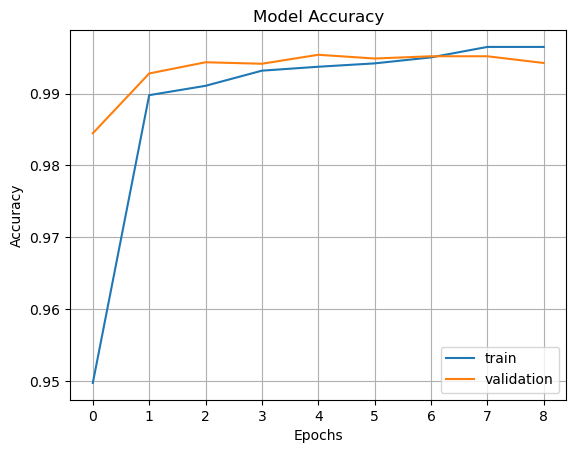

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.show()

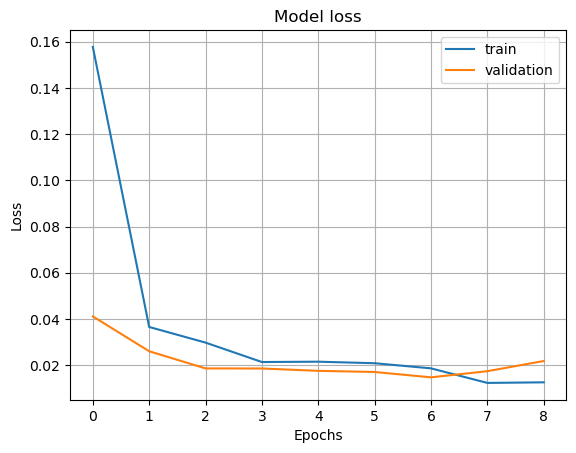

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.axis(ymin=0.001,ymax=0.3)
# plt.axis(xmin=0.4,xmax=5)
plt.grid()
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.show()

In [13]:
test_set = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/valid',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=1,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    shuffle=False,
)

Found 9600 files belonging to 8 classes.


In [14]:
class_name = test_set.class_names
class_name

['Apple', 'Corn', 'Grape', 'Other', 'Potato', 'Strawberry', 'Tomato', 'Wheat']

In [15]:
y_pred = resnet50_model.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)

9600/9600 [==============================] - 209s 22ms/step


In [16]:
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

In [17]:
Y_true

<tf.Tensor: shape=(9600,), dtype=int64, numpy=array([0, 0, 0, ..., 7, 7, 7], dtype=int64)>

In [18]:
predicted_categories

<tf.Tensor: shape=(9600,), dtype=int64, numpy=array([0, 0, 0, ..., 7, 7, 7], dtype=int64)>

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_true,predicted_categories)

In [20]:
print(classification_report(Y_true,predicted_categories,target_names=class_name))

              precision    recall  f1-score   support

       Apple       1.00      0.92      0.96      1200
        Corn       1.00      1.00      1.00      1200
       Grape       0.99      0.98      0.99      1200
       Other       1.00      1.00      1.00      1200
      Potato       0.96      0.99      0.97      1200
  Strawberry       0.96      1.00      0.98      1200
      Tomato       0.97      0.98      0.98      1200
       Wheat       1.00      1.00      1.00      1200

    accuracy                           0.98      9600
   macro avg       0.98      0.98      0.98      9600
weighted avg       0.98      0.98      0.98      9600



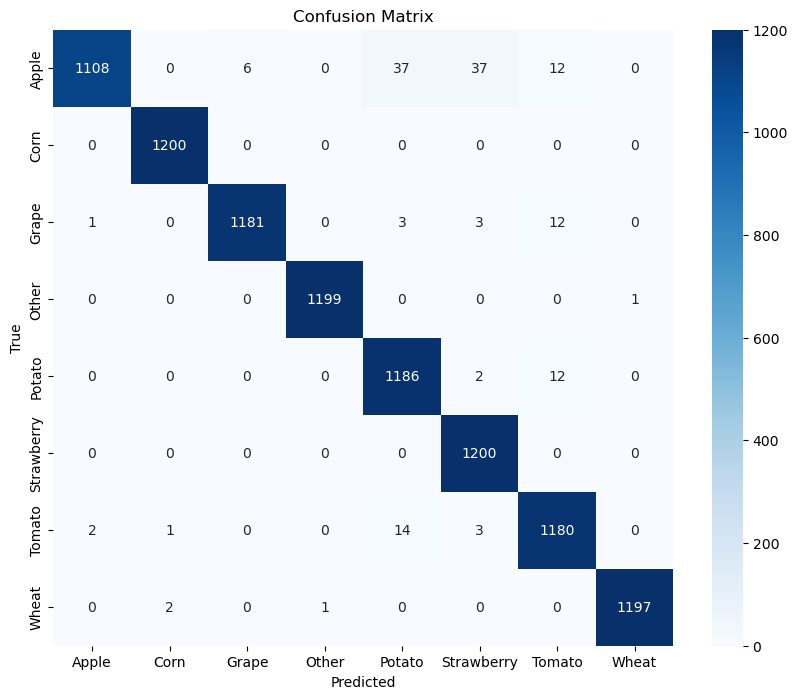

In [23]:
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
from tensorflow.keras.models import load_model
resnet50_model.save('CropIdentificationModel.h5')